In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import torch

Uses FastAI v0.7 version for this project. To get the correct version, please use the README file.

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Here are some of the project variables we use for convenience
- version: to keep track of the different versions we are iterating through, we can change this parameter
- PATH: this is where we keep our train and test images, in this folder exists 2 other folders test and train
- sz: this is the image size we are using 224 x 224
- arch: we will use resnet34 mostly


In [5]:
version = 10
PATH = "./clean-data/"
TMP_PATH = f"/tmp/tmp/resnet34_{version}"
MODEL_PATH = f"/tmp/model/resnet34_{version}"
sz=224
arch=resnet34

The next 2 cells we check that all cuda related resources have been correctly setup.

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.backends.cudnn.enabled

True

Here we show the subdirectories of this project. If you do not have the images, remember to get from Kaggle first. Check out the readme file.

In [8]:
os.listdir(PATH)

['test', 'train']

Loop through the train directory and create the respective filenames and labels. These 2 numpy arrays are used in subsequent model initialization.

In [9]:
fnames = np.array([f'train/{f}' for f in sorted(os.listdir(f'{PATH}train'))])
labels = np.array([(0 if 'cat' in fname else 1) for fname in fnames])

We create a data object and pass it through to the pretrained method. This uses a pretrained resnet34 model. We can also see the results after training for a short 2 epochs.

In [10]:
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['dogs', 'cats'], 
    test_name='test', 
    tfms=tfms_from_model(arch, sz)
)
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)
learn.fit(1e-3, 2)


epoch      trn_loss   val_loss   accuracy                     
    0      0.069045   0.040885   0.986787  
    1      0.058908   0.032642   0.989389                      



[array([0.03264]), 0.9893893893893894]

In the next few cells, we will just output the different attributes on the data object, this helps us get a good grasp of what the data object and learn object looks like.

In [11]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [12]:
data.classes

['dogs', 'cats']

In [13]:
log_preds = learn.predict()
log_preds.shape

(4995, 2)

In [14]:
log_preds[:10]


array([[-0.02186, -3.8342 ],
       [-0.03267, -3.43751],
       [-0.00062, -7.38737],
       [-0.00349, -5.65864],
       [-0.00097, -6.93908],
       [-0.00296, -5.82358],
       [-0.00053, -7.5373 ],
       [-0.00285, -5.86016],
       [-0.00033, -8.00481],
       [-0.00188, -6.27804]], dtype=float32)

In [15]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
probs


array([0.02162, 0.03214, 0.00062, ..., 0.99964, 0.99969, 0.99649], dtype=float32)

In [16]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 20, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [17]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])


The following functions give us a good idea of how wrong an image is and also prints out the image and the filename to ensure that the image is not mislabled.

As we are changing different parameters and experimenting with different techniques, I found quite a few mislabeled images and I have removed and renamed images that are,
1. mislabled
2. contain cat and dog in one image
3. do not contain cat or dog in one image


In [18]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [str(probs[x]) + "\r\n[" + data.val_ds.fnames[x] + "]" for x in idxs]
    print(title)
    return plots(imgs, rows=5, titles=title_probs, figsize=(16,10))


Correctly classified


/home/jie/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/jie/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


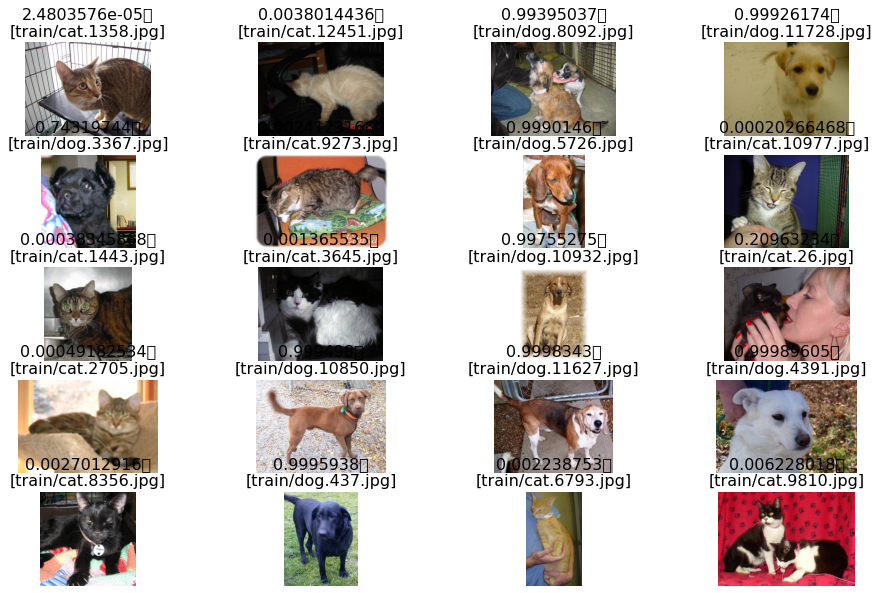

In [19]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")


Incorrectly classified


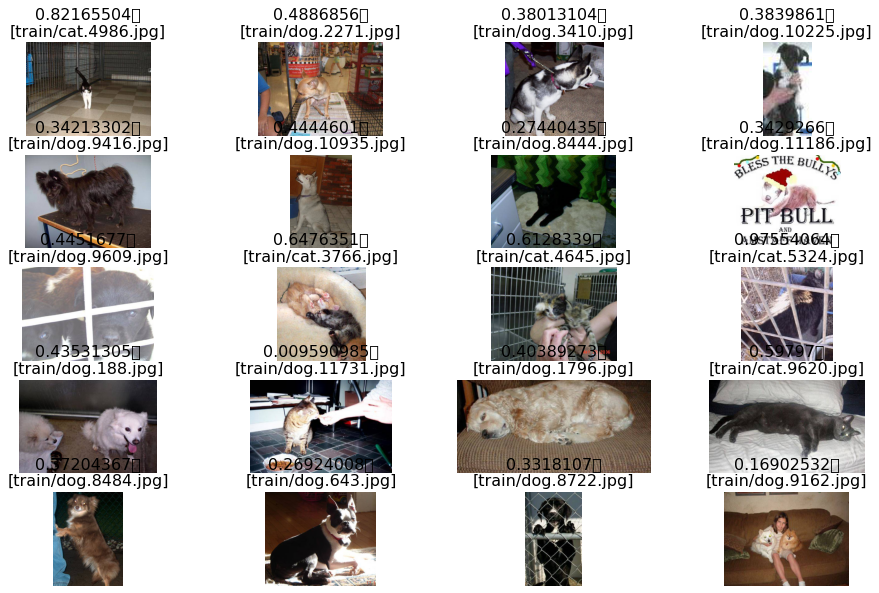

In [20]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")


In [21]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:20]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)


Most correct cats


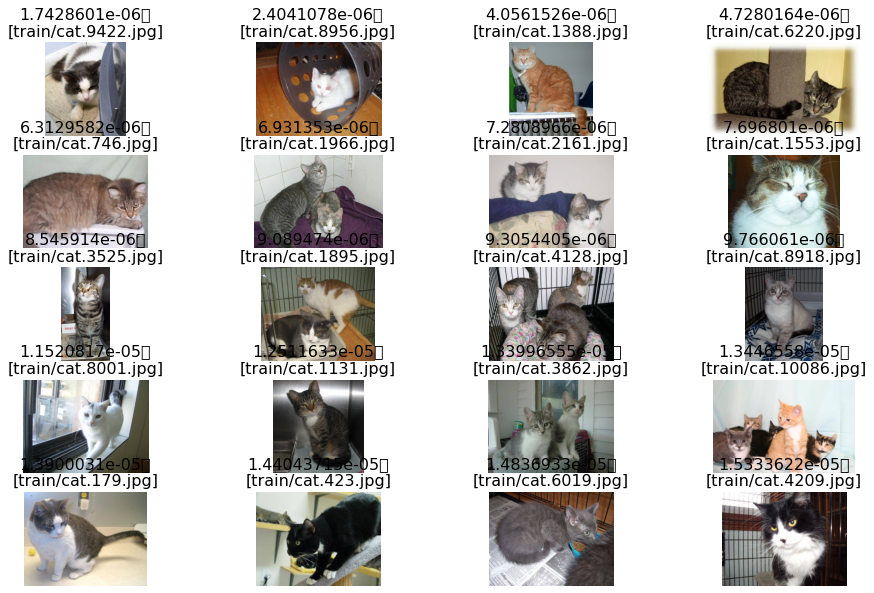

In [22]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")


Most correct dogs


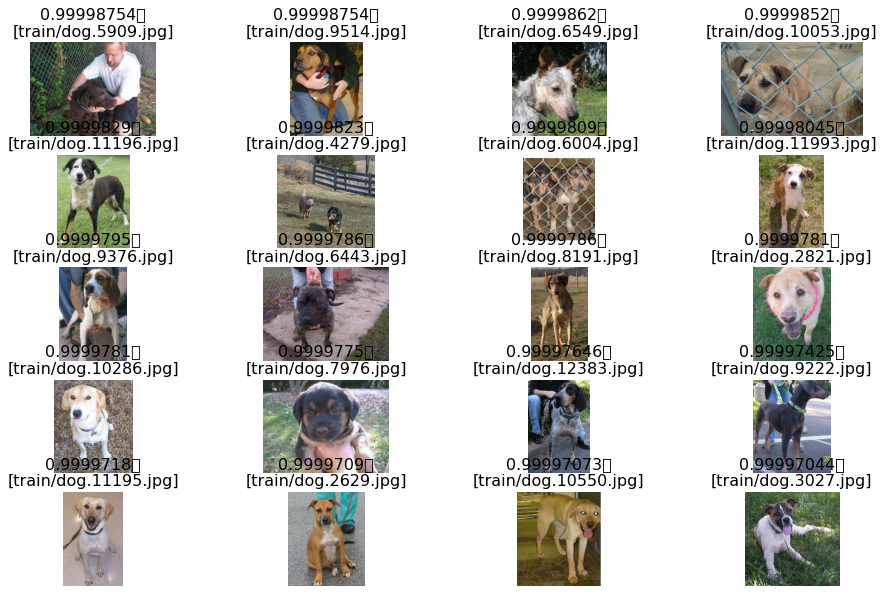

In [23]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")


Most incorrect cats


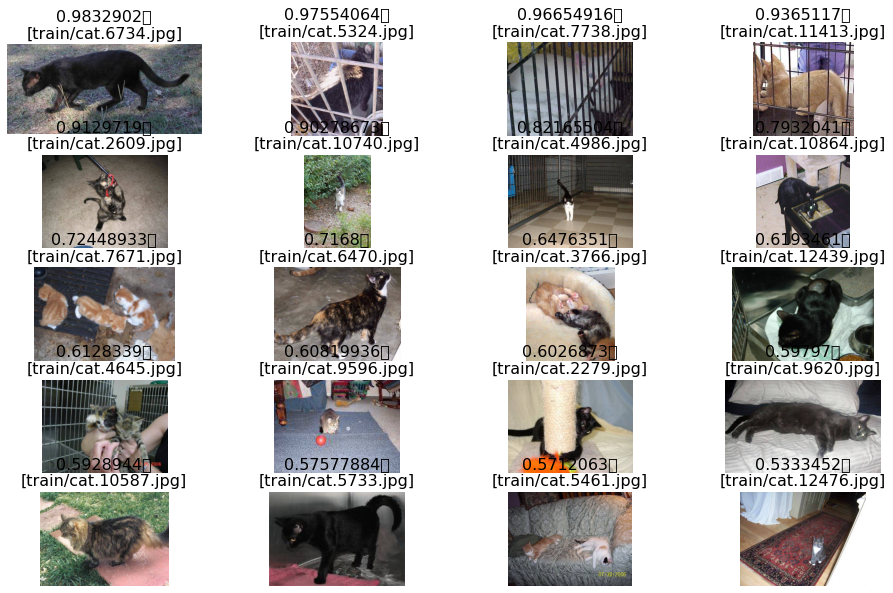

In [24]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")


Most incorrect dogs


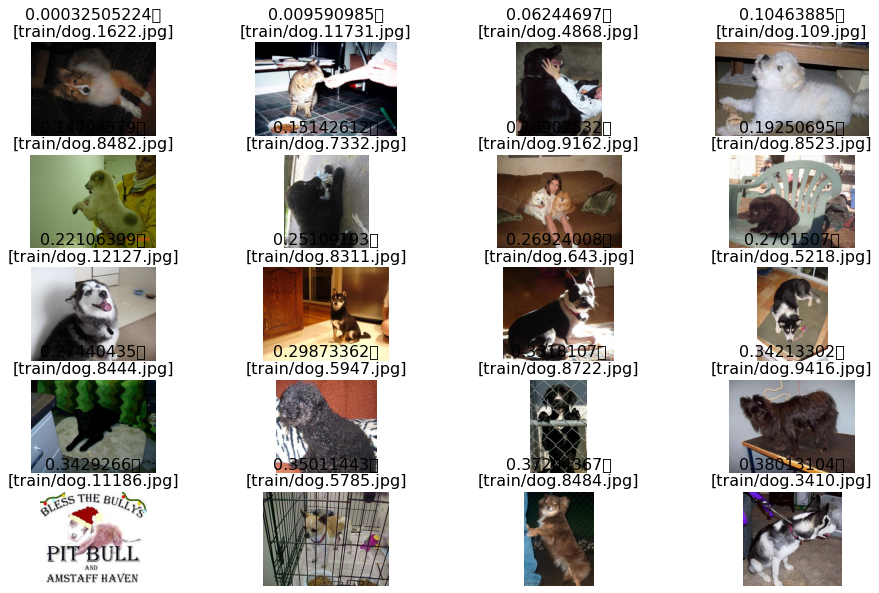

In [25]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")


Most uncertain predictions


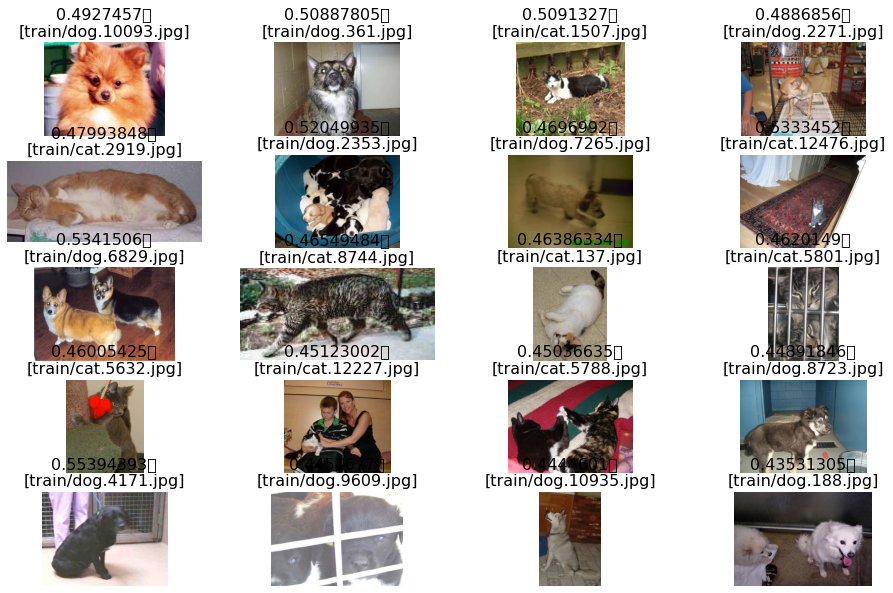

In [26]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:20]
plot_val_with_title(most_uncertain, "Most uncertain predictions")


In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)


In [28]:
lrf=learn.lr_find()


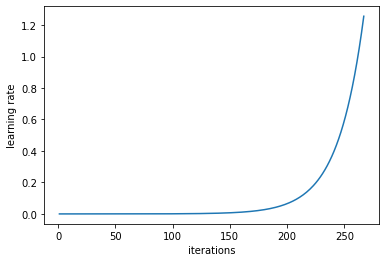

In [29]:
learn.sched.plot_lr()


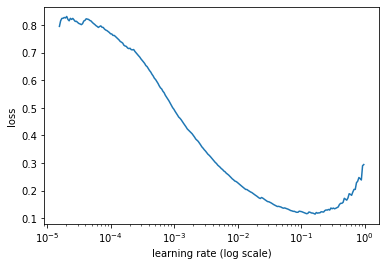

In [30]:
learn.sched.plot()


To use data augmentation, we first need to define what kind of transformations that we want to achieve. I decided on the few because I found that in the first few iteration, the model wasn't very certain about cat and dogs that have their images rotated or with different type of lightings. So here, I chose to add those into the transformations

In [31]:
transforms = transforms_side_on + [
    RandomRotate(180, p=0.75, mode=cv2.BORDER_REFLECT, tfm_y=TfmType.NO),
    RandomLighting(b=0.5, c=0, tfm_y=TfmType.NO),
    RandomZoom(zoom_max=1)
]
tfms = tfms_from_model(arch, sz, aug_tfms=transforms, max_zoom=1.1)

In [32]:
def get_augs():
    data = ImageClassifierData.from_names_and_array(
        path=PATH, 
        fnames=fnames, 
        y=labels, 
        classes=['dogs', 'cats'], 
        test_name='test', 
        tfms=tfms,
        num_workers=1,
        bs=2
    )

    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [33]:
ims = np.stack([get_augs() for i in range(9)])

A quick visualization of how the images look after transformation.

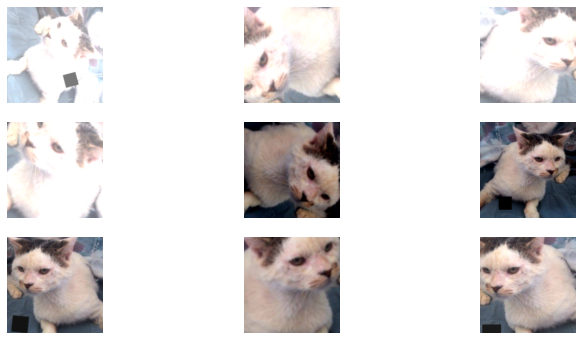

In [34]:
plots(ims, rows=3)

We add the transformation as a parameter to the data object creation.

In [35]:
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['dogs', 'cats'], 
    test_name='test', 
    tfms=tfms
)
learn = ConvLearner.pretrained(arch, data, precompute=True, tmp_name=TMP_PATH, models_name=MODEL_PATH)

In [36]:
learn.fit(1e-3, 1)

epoch      trn_loss   val_loss   accuracy                      
    0      0.080668   0.042629   0.986787  



[array([0.04263]), 0.9867867867867868]

In [37]:
learn.precompute=False

We then proceed to train the model's last layer while keeping all the other layers untouched. Here we can see that there is only that much improvement we can gain from doing so.

In [38]:
learn.fit(1e-3, 20, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.240427   0.038932   0.988989  
    1      0.250497   0.040727   0.987588                    
    2      0.239487   0.0361     0.99039                     
    3      0.214277   0.03631    0.98999                     
    4      0.220862   0.034797   0.990991                    
    5      0.21667    0.036236   0.98999                     
    6      0.215834   0.03321    0.991792                    
    7      0.221289   0.034391   0.99039                     
    8      0.216508   0.032861   0.991191                    
    9      0.222966   0.033952   0.990791                    
    10     0.206987   0.032054   0.991191                    
    11     0.203844   0.032592   0.990791                    
    12     0.205231   0.032146   0.990591                    
    13     0.21129    0.031858   0.990791                    
    14     0.205999   0.032222   0.990991                    
    15     0.211383   0.03

[array([0.02886]), 0.9911911911911911]

To properly visualize learning rate annealing, we can see below a spikey graph. Each of the spike is when the restarts happens for the SGD with restarts.

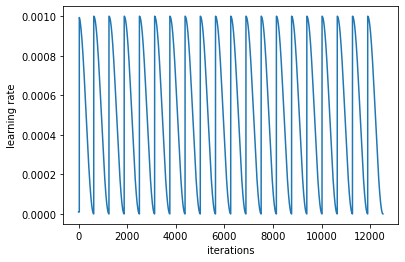

In [39]:
learn.sched.plot_lr()


Next, we want to now retrain the other layers, so we save and load.

In [40]:
learn.save('224_lastlayer')


In [41]:
learn.load('224_lastlayer')


We then unfreeze the earlier layers.

In [42]:
learn.unfreeze()


Here, we set the different learning rates. The first few layers, since they identify very basic edges, we will set a learning rate that is much lower such as 13-4, the middle layers we will train with learning rate of 1e-3, finally we will then train the last few layers with learning rate of 1e-2.

This is the part where we will apply differential learning rate annealing. The differential part happens when we pass a cycle_mult of 2. We can also visualize this later in the graph, we can see that each peak and through is getting wider with increasing number of epochs.

In [43]:
lr=np.array([1e-4,1e-3,1e-2])

In [44]:
learn.fit(lr, 6, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   accuracy                    
    0      0.190831   0.049065   0.982983  
    1      0.16624    0.03888    0.986987                    
    2      0.141265   0.036554   0.988989                    
    3      0.138532   0.031759   0.987588                    
    4      0.117481   0.029631   0.988589                    
    5      0.120785   0.029291   0.98979                     
    6      0.121468   0.028023   0.98959                     
    7      0.116758   0.0267     0.98999                     
    8      0.110775   0.028906   0.988989                    
    9      0.112308   0.027137   0.990591                    
    10     0.105847   0.023726   0.992392                    
    11     0.09612    0.022807   0.991391                     
    12     0.10304    0.02257    0.991992                     
    13     0.105602   0.022309   0.991792                     
    14     0.095256   0.0241     0.98999                      
    15     0.102542   

[array([0.02048]), 0.9931931931931932]

Visualizing differential learning rate.

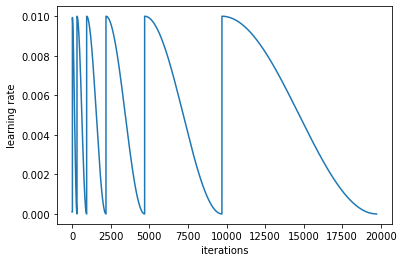

In [45]:
learn.sched.plot_lr()

In [46]:
learn.save('224_all')


In [47]:
learn.load('224_all')


In [48]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [49]:
accuracy_np(probs, y)

0.98998998998999

In [50]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]


In [51]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)


[[2500   31]
 [  19 2445]]


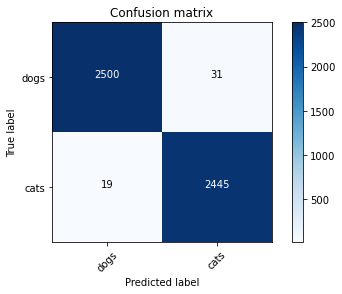

In [52]:
plot_confusion_matrix(cm, data.classes)


Most incorrect cats


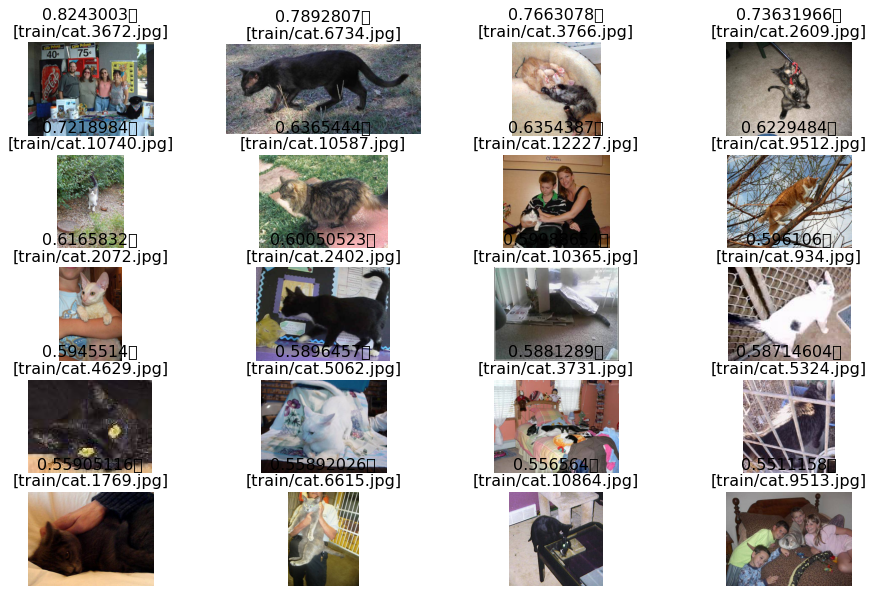

In [53]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")


Most incorrect dogs


ValueError: num must be 1 <= num <= 15, not 16

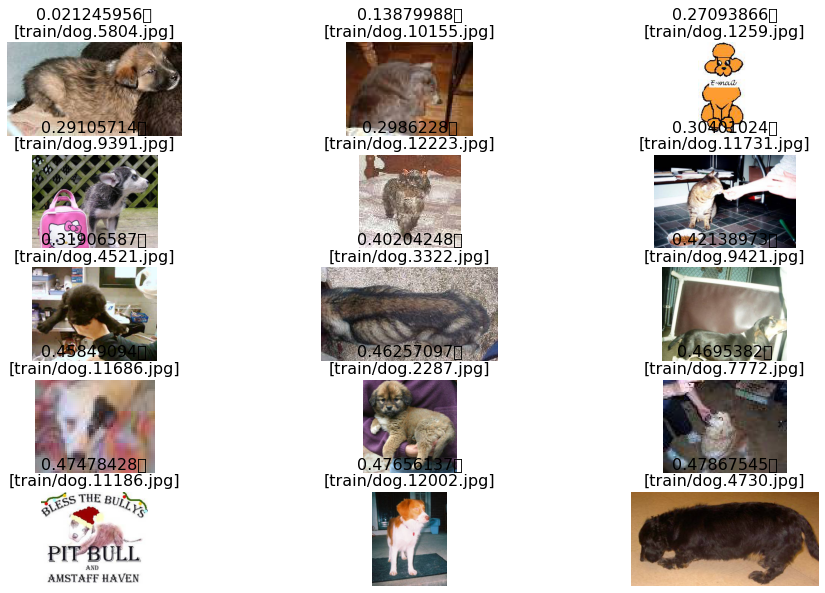

In [54]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")


Using the TTA function with is_test set to true, we are now using the Test Time Augmentation feature. During this step, we then take the mean of the results and calculate the probabaility. Finally, we take the probabilities that an image is a dog.

In [57]:
log_preds, y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)
probs_dogs = probs[:,1]

array([0.99992, 0.91794, 0.18977, ..., 0.00004, 0.99991, 0.99577], dtype=float32)

In the next couple of cells, we create the required submission and check that the format is correct.

In [58]:
import re
ids = [re.search(r'\d+',file).group() for file in data.test_ds.fnames]
submission = pd.DataFrame({'id':ids, 'label':probs_dogs})


In [59]:
submission = submission.sort_values(by=['id'])

In [60]:
submission.head()

id     label
11696      1  0.992784
2872      10  0.000017
5955     100  0.000230
6135    1000  0.999821
11108  10000  0.961073

In [61]:
submission.to_csv(f'submission-{version}.csv', index=False)

Some of the removed images
- dog.10801.jpg
- dog.8736.jpg
- cat.4338.jpg
- dog.7076.jpg
- dog.1835.jpg
- cat.724.jpg
- cat.7968.jpg
- cat.3531.jpg
- cat.7564.jpg